In [89]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.categorical import Categorical


class NeuralGMM(nn.Module):
    def __init__(self,
                 n_components,
                 n_dimensions=2,
                 n_inference_steps=5,
                 method_of_latent_variable_inference="gradient_descent",
                 lr_for_latent_variable_inference=0.1,
        ):
        """
        Args:
            n_components: number of components in the GMM
            n_dimensions: number of dimensions in the data
            n_inference_steps: number of inference steps for gradient descent
            method_of_latent_variable_inference: method to infer the latent variable
                "gradient_descent" or "analytical" (default: "gradient_descent")
        """
        super().__init__()
        self.n_components = n_components
        self.n_dimensions = n_dimensions
        self.n_inference_steps = n_inference_steps
        self.method_of_latent_variable_inference = method_of_latent_variable_inference
        self.lr_for_latent_variable_inference = lr_for_latent_variable_inference
        # Decoder parameters (learnable Gaussian parameters)
        self.means = nn.Parameter(torch.randn(n_components, n_dimensions))
        self.log_vars = nn.Parameter(torch.zeros(n_components, n_dimensions))
        self.prior_logits = nn.Parameter(torch.zeros(n_components))
        
    def get_component_distributions(self):
        vars = torch.exp(self.log_vars)
        covs = torch.stack([torch.diag(var) for var in vars])
        return [MultivariateNormal(mean, cov) for mean, cov in zip(self.means, covs)]

    def infer_assignments(self, x):
        """Infer component assignments for a batch of data points"""
        if self.method_of_latent_variable_inference == "gradient_descent":
            return self.infer_assignments_by_gradient_descent(x)
        else:
            return self.infer_assignments_analytically(x)
    
    def reconstruct(self, x):
        """Reconstruct x from the model"""
        assignments = self.infer_assignments(x)  # Shape: [batch_size, n_components]
        components = self.get_component_distributions()
        means = torch.stack([comp.mean for comp in components])  # Shape: [n_components, n_dimensions]
        # Use matrix multiplication to weight the means by assignments
        recon_data = torch.matmul(assignments, means)  # Shape: [batch_size, n_dimensions]
        # add noise according to the variance
        # Expand log_vars to match batch size
        expanded_log_vars = self.log_vars.unsqueeze(0).expand(assignments.shape[0], -1, -1)
        # Take weighted sum of variances according to assignments
        weighted_log_vars = torch.sum(assignments.unsqueeze(-1) * expanded_log_vars, dim=1)
        noise = torch.randn_like(recon_data) * torch.exp(weighted_log_vars)
        recon_data = recon_data + noise
        return recon_data

    def get_mixture_distribution(self):
        """Get the mixture distribution of the model"""
        components = self.get_component_distributions()
        mixing_coeffs = torch.softmax(self.prior_logits, dim=0)
        return components, mixing_coeffs
    
    def infer_assignments_analytically(self, x):
        """Softmax inference of component assignments"""
        components = self.get_component_distributions()
        log_probs = torch.stack([comp.log_prob(x) for comp in components], dim=1)
        return torch.softmax(log_probs, dim=1)  # also works if detach

    def infer_assignments_by_gradient_descent(self, x, n_steps=None):
        if n_steps is None:
            n_steps = self.n_inference_steps
        learning_rate = self.lr_for_latent_variable_inference
        
        """Gradient-based inference of component assignments"""
        # Initialize assignment logits randomly
        batch_size = x.shape[0]
        assignment_logits = torch.randn(batch_size, self.n_components, requires_grad=True)
        
        # Get component distributions
        components = self.get_component_distributions()
        
        # Gradient descent to optimize assignments
        optimizer = torch.optim.Adam([assignment_logits], lr=learning_rate)
        
        for step in range(n_steps):
            optimizer.zero_grad()
            
            # Get current soft assignments
            assignments = torch.softmax(assignment_logits, dim=1)
            
            # Compute log probabilities for each component
            with torch.no_grad():
                log_probs = torch.stack([comp.log_prob(x) for comp in components], dim=1)
            
            # Add prior
            prior_log_probs = torch.log_softmax(self.prior_logits, dim=0)
            
            # Compute negative ELBO
            # E_q[log p(x|z) + log p(z) - log q(z)]
            elbo = (assignments * (log_probs + prior_log_probs - torch.log(assignments + 1e-10))).sum(1).mean()
            
            # Maximize ELBO
            loss = -elbo
            loss.backward(retain_graph=True)  # Added retain_graph=True to allow multiple backwards passes
            optimizer.step()
        
        # soft_assignments = torch.softmax(assignment_logits.detach(), dim=1)
        soft_assignments = torch.softmax(assignment_logits, dim=1)
        # for debug, compare with analytical solution
        debug = False
        if debug:
            analytical_assignments = self.infer_assignments_analytically(x)
            print(f"soft_assignments: {soft_assignments.detach().argmax(dim=1).numpy()[:10]}")
            print(f"analytical_assignments: {analytical_assignments.detach().argmax(dim=1).numpy()[:10]}")
            # print(f"difference between soft_assignments and analytical_assignments: {torch.norm(soft_assignments - analytical_assignments).item():.4f}")

        return soft_assignments  # .detach()
    
    def forward(self, x):
        # Infer assignments using gradient descent
        assignments = self.infer_assignments(x)
        
        # Get component distributions
        components = self.get_component_distributions()
        
        # Compute log probabilities for each component
        log_probs = torch.stack([comp.log_prob(x) for comp in components], dim=1)
        
        # Compute log likelihood using current assignments
        log_likelihood = (assignments * log_probs).sum(1).mean()
        
        return -log_likelihood
    
    def sample(self, n_samples):
        """Generate new samples from the model"""
        with torch.no_grad():
            p_z = Categorical(logits=self.prior_logits)
            z = p_z.sample((n_samples,))
            
            components = self.get_component_distributions()
            samples = torch.stack([components[zi].sample() for zi in z])
        return samples

# Generate data
n_samples = 1000
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)
X = X[:, [0, 2]]
X = torch.FloatTensor(X)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# Training setup
n_components = 10
model = NeuralGMM(
    n_components=n_components,
    method_of_latent_variable_inference="analytical",
    ##
    # method_of_latent_variable_inference="gradient_descent",
    # lr_for_latent_variable_inference=2,
    # n_inference_steps=15,
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    # The training loop is by gradient descent.
    # For Gaussian Mixture Models, you can also do it analytically.
    optimizer.zero_grad()
    loss = model(X)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')

model.eval()

Epoch 100/1000, Loss: 2.1118
Epoch 200/1000, Loss: 1.4716
Epoch 300/1000, Loss: 0.7736
Epoch 400/1000, Loss: 0.3101
Epoch 500/1000, Loss: 0.0401
Epoch 600/1000, Loss: -0.1353
Epoch 700/1000, Loss: -0.2558
Epoch 800/1000, Loss: -0.3368
Epoch 900/1000, Loss: -0.3859
Epoch 1000/1000, Loss: -0.4148


NeuralGMM()

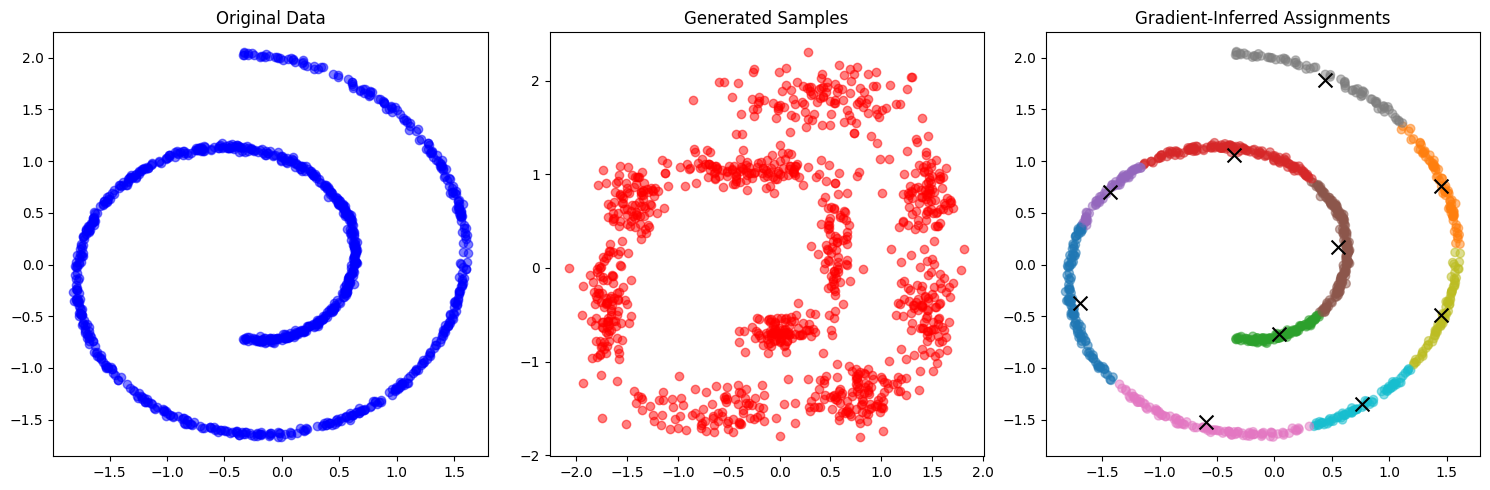

In [90]:

def plot_comparison(X, model):
    plt.figure(figsize=(15, 5))
    
    # Original data
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5)
    plt.title('Original Data')
    
    # Generated samples
    plt.subplot(132)
    with torch.no_grad():
        samples = model.sample(n_samples=1000)
    plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), c='red', alpha=0.5)
    plt.title('Generated Samples')
    
    # Inferred assignments
    plt.subplot(133)
    assignments = model.infer_assignments(X)
    hard_assignments = assignments.argmax(dim=1)
    plt.scatter(X[:, 0], X[:, 1], c=hard_assignments, cmap='tab10', alpha=0.5)
    plt.scatter(model.means.detach()[:, 0], model.means.detach()[:, 1], 
                c='black', marker='x', s=100)
    plt.title('Gradient-Inferred Assignments')
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_comparison(X, model)

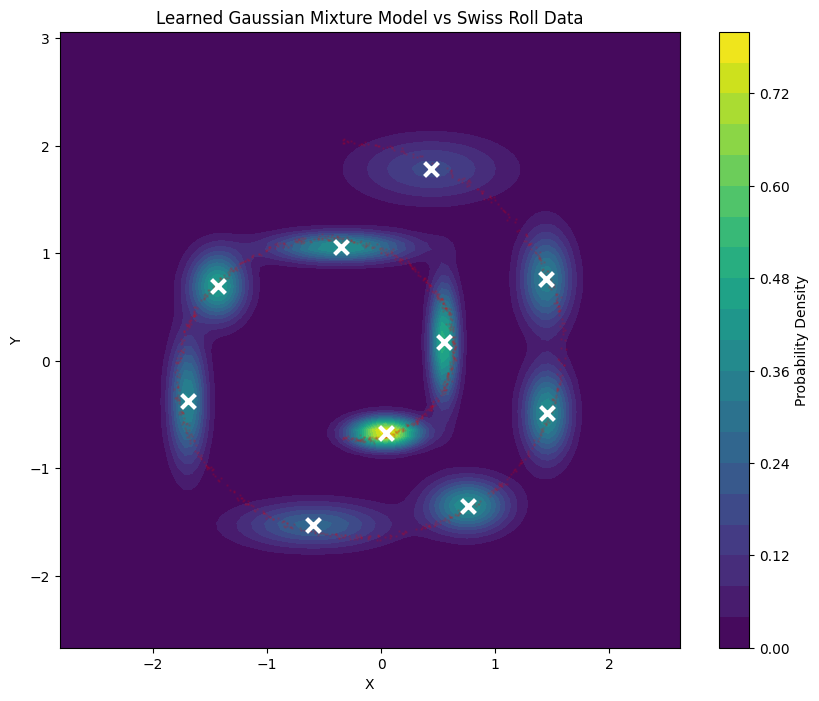

In [91]:
def plot_density(X, model):
    # Create a grid of points
    x = np.linspace(X[:, 0].min().item() - 1, X[:, 0].max().item() + 1, 100)
    y = np.linspace(X[:, 1].min().item() - 1, X[:, 1].max().item() + 1, 100)
    xx, yy = np.meshgrid(x, y)
    grid_points = torch.FloatTensor(np.column_stack([xx.ravel(), yy.ravel()]))
    
    # Evaluate log probability on grid
    with torch.no_grad():
        components, mixing_coeffs = model.get_mixture_distribution()
        component_likelihoods = torch.stack([comp.log_prob(grid_points) for comp in components])
        logits = component_likelihoods + torch.log(mixing_coeffs.unsqueeze(1))
        log_prob = torch.logsumexp(logits, dim=0)
        prob = torch.exp(log_prob).reshape(100, 100)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, prob.numpy(), levels=20)
    plt.colorbar(label='Probability Density')
    plt.scatter(X[:, 0], X[:, 1], c='red', alpha=0.1, s=1)
    
    # Plot component means
    means = model.means.detach().numpy()
    plt.scatter(means[:, 0], means[:, 1], c='white', marker='x', s=100, linewidths=3)
    
    plt.title('Learned Gaussian Mixture Model vs Swiss Roll Data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Plot the results
plot_density(X, model)

shape of X: torch.Size([1000, 2])
shape of recon_data: (1000, 2)


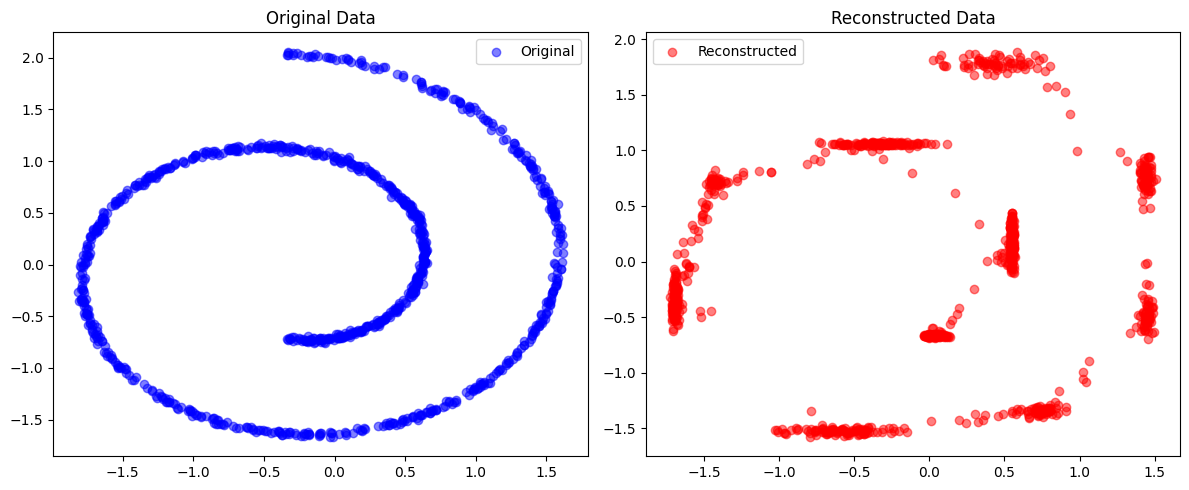

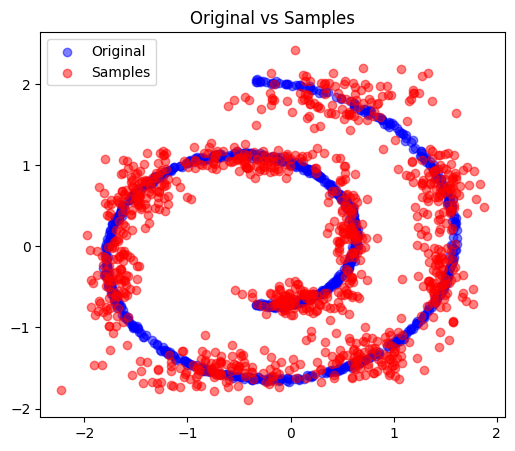

Chamfer Distance: 0.0285


In [92]:
from chamferdist import chamfer_distance

model.eval()

# Get reconstructions
recon_data = model.reconstruct(X)
recon_data = recon_data.detach().numpy()

# get samples
with torch.no_grad():
    samples = model.sample(1000)
    samples = samples.numpy()


# Visualization functions
def plot_original_vs_reconstructed():
    print(f"shape of X: {X.shape}")
    print(f"shape of recon_data: {recon_data.shape}")
    with torch.no_grad():
        
        # Plot
        plt.figure(figsize=(12, 5))
        
        plt.subplot(121)
        plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
        plt.title('Original Data')
        plt.legend()
        
        plt.subplot(122)
        plt.scatter(recon_data[:, 0], recon_data[:, 1], c='red', alpha=0.5, label='Reconstructed')
        plt.title('Reconstructed Data')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


def plot_original_vs_samples():
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
    plt.scatter(samples[:, 0], samples[:, 1], c='red', alpha=0.5, label='Samples')
    plt.title('Original vs Samples')
    plt.legend()
    plt.show()


plot_original_vs_reconstructed()
plot_original_vs_samples()

# compute chamfer distance
cd = chamfer_distance(X.cpu().numpy(), samples)
print(f"Chamfer Distance: {cd.item():.4f}")